In [1]:
!pip install -U sentence-transformers -q

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, confusion_matrix
import gc

plt.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/kaggle/input/chatgpt-app-reviews/chatgpt_reviews.csv')
data.head()

,date,title,review,rating
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4


## QUICK EDA

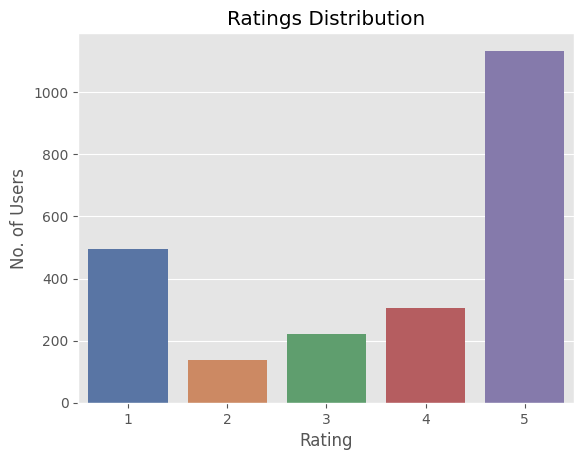

In [4]:
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

In [5]:
data['complete_review'] = data['title'] +' .'+data['review']

In [6]:
data['complete_review'] = data['complete_review'].apply(lambda x: re.sub(r'\W+', ' ', x))
data.complete_review

0       Much more accessible for blind users than the ...
1       Much anticipated wasn t let down I ve been a u...
2       Almost 5 stars but no search function This app...
3       4 5 stars here s why I recently downloaded the...
4       Good but Siri support would take it to the nex...
                              ...                        
2287    Andrew Justino Wilson 5 19 23 This has to be a...
2288    Superb AI I ve been using chat and have been a...
2289    Fantastic App with Room for Enhancements The C...
2290    Awesome technology deplorable tactics Sam Altm...
2291              I like how there r no limits thanks 33 
Name: complete_review, Length: 2292, dtype: object

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [15]:
sample = data['complete_review'][0]

In [8]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,date,title,review,rating,complete_review,sentiment
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4,Much more accessible for blind users than the ...,2
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4,Much anticipated wasn t let down I ve been a u...,2
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4,Almost 5 stars but no search function This app...,2
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4,4 5 stars here s why I recently downloaded the...,2
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4,Good but Siri support would take it to the nex...,2


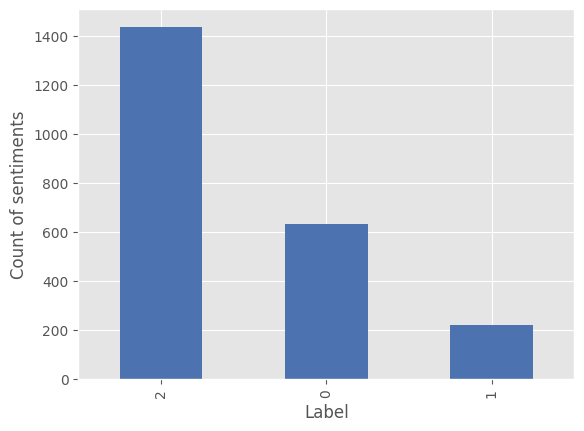

In [9]:
data.sentiment.value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count of sentiments')
plt.show()

## Train test split

In [10]:
train_text,test_text,train_label,test_label = train_test_split(data.complete_review,data.sentiment,
                                                              test_size=0.2,
                                                              random_state=42)

In [11]:
## Load the Sentence Transformer model
model = SentenceTransformer('thenlper/gte-large')

In [12]:
## Generate Embeddings
train_embeddings = model.encode(train_text.to_list(),convert_to_tensor=True)
test_embeddings = model.encode(test_text.to_list(),convert_to_tensor=True)

## Convert to numpy array
train_embeddings = train_embeddings.cpu().numpy()
test_embeddings = test_embeddings.cpu().numpy()

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

## Modelling

In [13]:
gc.collect()
classifier = CatBoostClassifier(learning_rate=0.0015,
                           iterations=550,
                           silent=True)
classifier.fit(train_embeddings,train_label)
cat_preds = classifier.predict(test_embeddings)

In [14]:
report = classification_report(test_label, cat_preds)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.69      0.75       127
           1       0.00      0.00      0.00        39
           2       0.80      0.97      0.88       293

    accuracy                           0.81       459
   macro avg       0.54      0.55      0.54       459
weighted avg       0.74      0.81      0.77       459



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
import pickle

with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)